# 📊 Exploratory Data Analysis (EDA)
## Insurance Claims Cost Prediction

**Objective**: Understand the training dataset to inform feature engineering and model selection for predicting `UltimateIncurredClaimCost`.

---

### Table of Contents
1. [Data Loading & Overview](#1-data-loading--overview)
2. [Missing Values Analysis](#2-missing-values-analysis)
3. [Target Variable Analysis](#3-target-variable-analysis)
4. [Numerical Features Distribution](#4-numerical-features-distribution)
5. [Categorical Features Analysis](#5-categorical-features-analysis)
6. [Correlation Analysis](#6-correlation-analysis)
7. [Feature vs Target Relationships](#7-feature-vs-target-relationships)
8. [Outlier Detection](#8-outlier-detection)
9. [Key Insights & Recommendations](#9-key-insights--recommendations)

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

---
## 1. Data Loading & Overview

In [2]:
# Load the training dataset
df = pd.read_csv('data/train.csv')

print(f"Dataset Shape: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Dataset Shape: 54000 rows, 15 columns
Memory Usage: 28.76 MB


### ⚠️ Data Cleaning
Renaming column `InitialIncurredCalimsCost` to correct the typo.

In [3]:
# Fix column name typo
if 'InitialIncurredCalimsCost' in df.columns:
    df.rename(columns={'InitialIncurredCalimsCost': 'InitialIncurredClaimsCost'}, inplace=True)
    print("Column 'InitialIncurredCalimsCost' renamed to 'InitialIncurredClaimsCost'")

Column 'InitialIncurredCalimsCost' renamed to 'InitialIncurredClaimsCost'


In [4]:
# First 5 rows
df.head()

,ClaimNumber,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredClaimsCost,UltimateIncurredClaimCost
0,WC8285054,2002-04-09T07:00:00Z,2002-07-05T00:00:00Z,48,M,M,0,0,500.00,F,38.00,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,1500,4748.20
1,WC6982224,1999-01-07T11:00:00Z,1999-01-20T00:00:00Z,43,F,M,0,0,509.34,F,37.50,5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,5500,6326.29
2,WC5481426,1996-03-25T00:00:00Z,1996-04-14T00:00:00Z,30,M,U,0,0,709.10,F,38.00,5,CUT ON SHARP EDGE CUT LEFT THUMB,1700,2293.95
3,WC9775968,2005-06-22T13:00:00Z,2005-07-22T00:00:00Z,41,M,S,0,0,555.46,F,38.00,5,DIGGING LOWER BACK LOWER BACK STRAIN,15000,17786.49
4,WC2634037,1990-08-29T08:00:00Z,1990-09-27T00:00:00Z,36,M,M,0,0,377.10,F,38.00,5,REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STR...,2800,4014.00


In [5]:
# Data Types and Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54000 entries, 0 to 53999
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ClaimNumber                54000 non-null  object 
 1   DateTimeOfAccident         54000 non-null  object 
 2   DateReported               54000 non-null  object 
 3   Age                        54000 non-null  int64  
 4   Gender                     54000 non-null  object 
 5   MaritalStatus              53971 non-null  object 
 6   DependentChildren          54000 non-null  int64  
 7   DependentsOther            54000 non-null  int64  
 8   WeeklyWages                54000 non-null  float64
 9   PartTimeFullTime           54000 non-null  object 
 10  HoursWorkedPerWeek         54000 non-null  float64
 11  DaysWorkedPerWeek          54000 non-null  int64  
 12  ClaimDescription           54000 non-null  object 
 13  InitialIncurredClaimsCost  54000 non-null  int

In [6]:
# Statistical Summary
df.describe()

,Age,DependentChildren,DependentsOther,WeeklyWages,HoursWorkedPerWeek,DaysWorkedPerWeek,InitialIncurredClaimsCost,UltimateIncurredClaimCost
count,54000.00,54000.00,54000.00,54000.00,54000.00,54000.00,54000.00,54000.00
mean,33.84,0.12,0.01,416.36,37.74,4.91,7841.15,11003.37
std,12.12,0.52,0.11,248.64,12.57,0.55,20584.08,33390.99
min,13.00,0.00,0.00,1.00,0.00,1.00,1.00,121.89
25%,23.00,0.00,0.00,200.00,38.00,5.00,700.00,926.34
50%,32.00,0.00,0.00,392.20,38.00,5.00,2000.00,3371.24
75%,43.00,0.00,0.00,500.00,40.00,5.00,9500.00,8197.25
max,81.00,9.00,5.00,7497.00,640.00,7.00,2000000.00,4027135.94


### 💡 Initial Observations
- **ClaimNumber**: Unique identifier (should be dropped for modeling)
- **Date columns**: `DateTimeOfAccident`, `DateReported` - potential for time-based features
- **Target**: `UltimateIncurredClaimCost` - this is what we need to predict
- **Categorical**: `Gender`, `MaritalStatus`, `PartTimeFullTime`
- **Numerical**: `Age`, `WeeklyWages`, `InitialIncurredCalimsCost`, etc.
- **Text**: `ClaimDescription` - potential for NLP features

---
## 2. Missing Values Analysis

In [7]:
# Missing values summary
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
}).sort_values('Missing %', ascending=False)

missing_df[missing_df['Missing Count'] > 0]

,Missing Count,Missing %
MaritalStatus,29,0.05


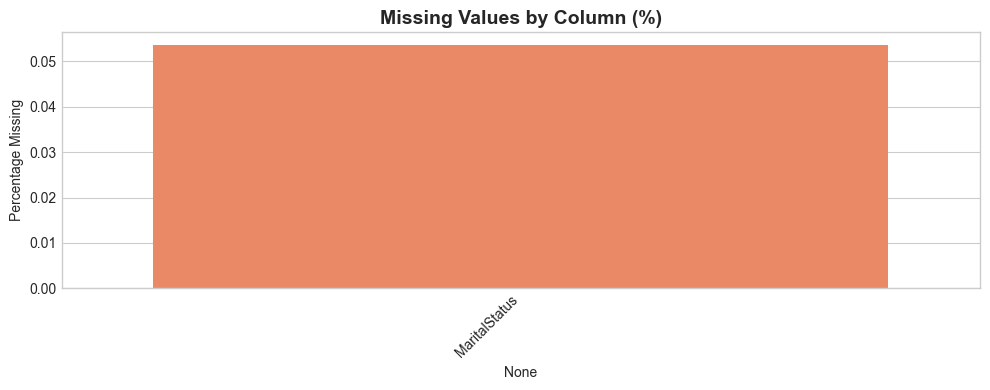

In [8]:
# Visualize missing values
if missing_df[missing_df['Missing Count'] > 0].shape[0] > 0:
    plt.figure(figsize=(10, 4))
    missing_cols = missing_df[missing_df['Missing Count'] > 0]
    sns.barplot(x=missing_cols.index, y='Missing %', data=missing_cols, color='coral')
    plt.title('Missing Values by Column (%)', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Percentage Missing')
    plt.tight_layout()
    plt.show()
else:
    print("✅ No missing values in the dataset!")

---
## 3. Target Variable Analysis

Understanding the distribution of `UltimateIncurredClaimCost` is critical for choosing the right model and loss function.

In [9]:
target = 'UltimateIncurredClaimCost'

print("Target Variable Statistics:")
print(df[target].describe())
print(f"\nSkewness: {df[target].skew():.2f}")
print(f"Kurtosis: {df[target].kurtosis():.2f}")

Target Variable Statistics:
count     54000.00
mean      11003.37
std       33390.99
min         121.89
25%         926.34
50%        3371.24
75%        8197.25
max     4027135.94
Name: UltimateIncurredClaimCost, dtype: float64

Skewness: 37.55
Kurtosis: 3940.86


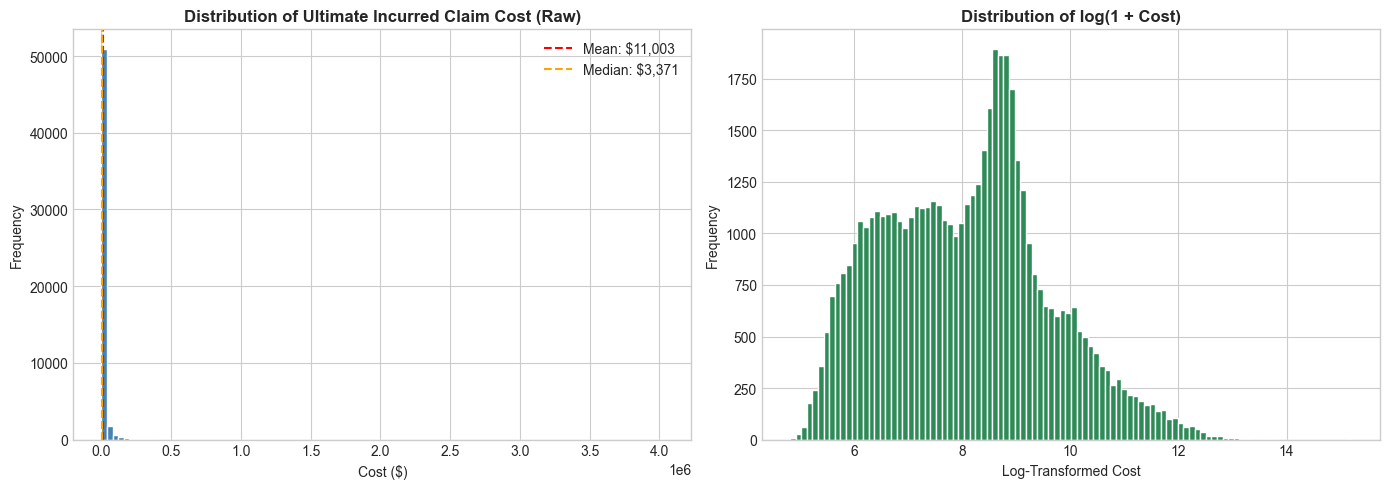

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw Distribution
axes[0].hist(df[target], bins=100, color='steelblue', edgecolor='white')
axes[0].set_title('Distribution of Ultimate Incurred Claim Cost (Raw)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Cost ($)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df[target].mean(), color='red', linestyle='--', label=f'Mean: ${df[target].mean():,.0f}')
axes[0].axvline(df[target].median(), color='orange', linestyle='--', label=f'Median: ${df[target].median():,.0f}')
axes[0].legend()

# Log-Transformed Distribution
log_target = np.log1p(df[target])
axes[1].hist(log_target, bins=100, color='seagreen', edgecolor='white')
axes[1].set_title('Distribution of log(1 + Cost)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Log-Transformed Cost')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### 📊 Target Insights

- **Extreme Right Skew (Skewness: 37.55)**: The raw distribution is heavily right-skewed, with a kurtosis of 3940.86, indicating extreme outliers.
- **Log Transformation**: Successfully normalizes the distribution, making it suitable for linear and tree-based models.
- **Zero-Inflation**: There are no zero-valued claims, but many low-value claims form the bulk of the distribution.

---
## 4. Numerical Features Distribution

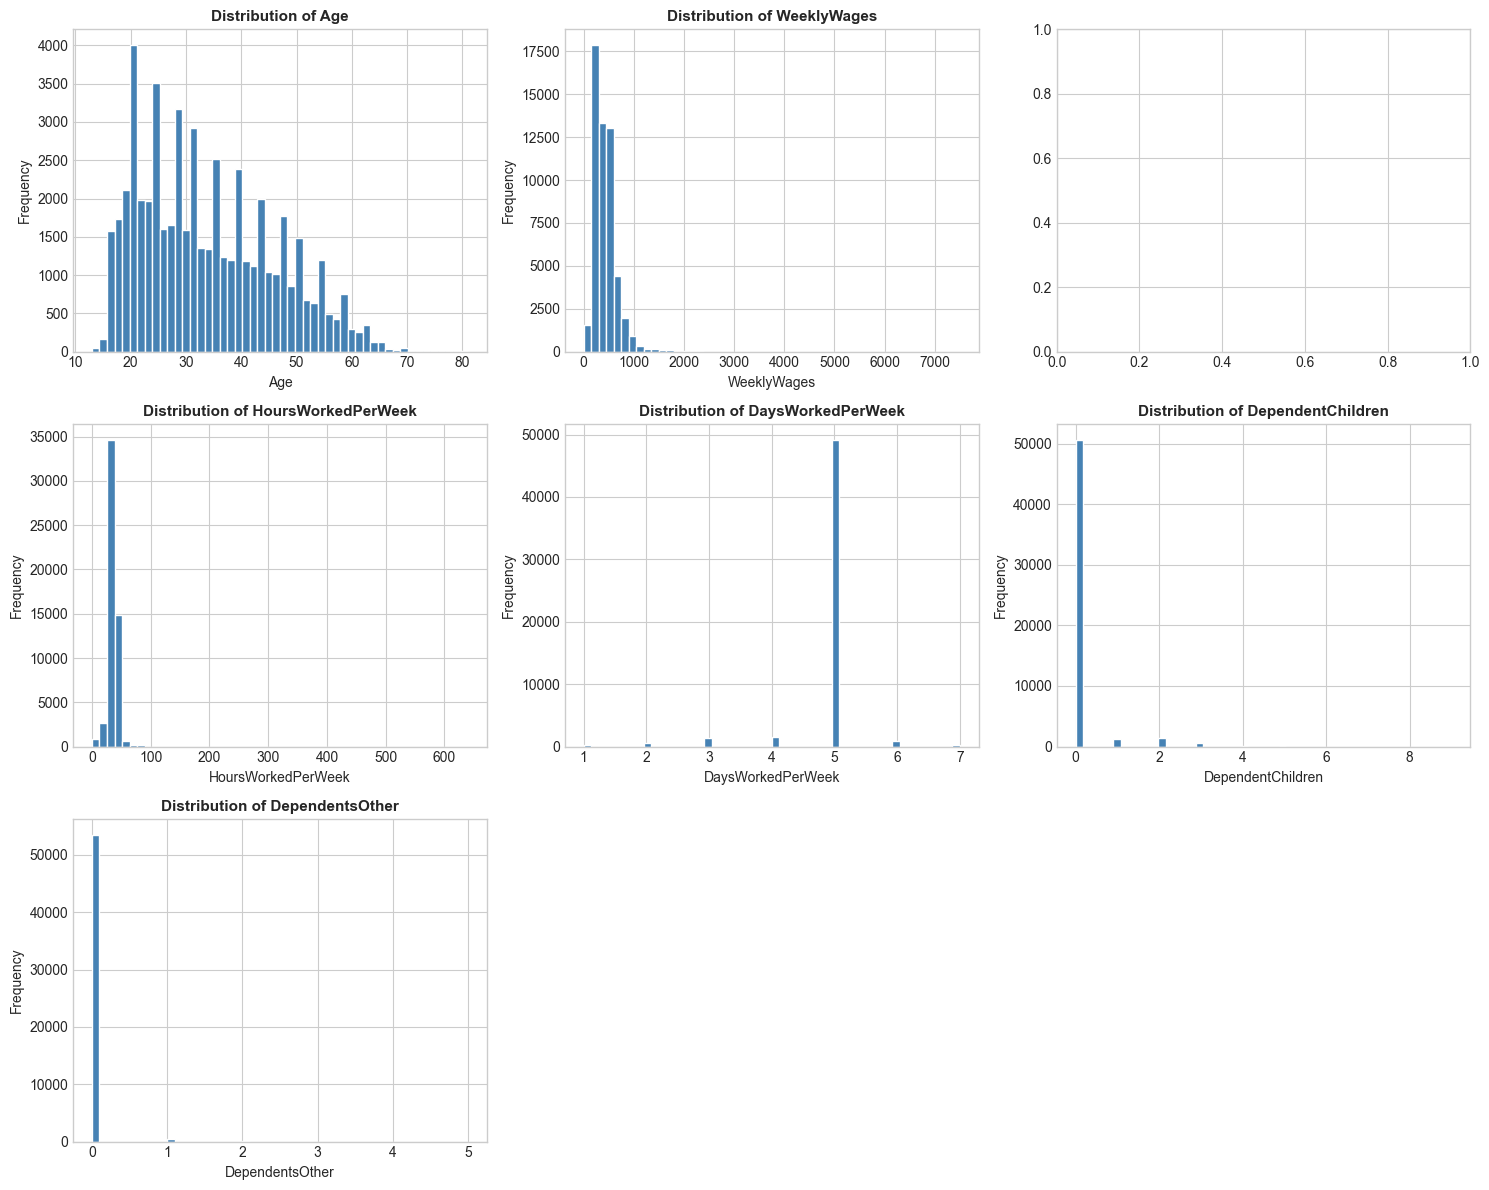

In [11]:
numerical_cols = ['Age', 'WeeklyWages', 'InitialIncurredCalimsCost', 
                  'HoursWorkedPerWeek', 'DaysWorkedPerWeek', 
                  'DependentChildren', 'DependentsOther']

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    if col in df.columns:
        axes[i].hist(df[col].dropna(), bins=50, color='steelblue', edgecolor='white')
        axes[i].set_title(f'Distribution of {col}', fontsize=11, fontweight='bold')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

# Hide unused subplots
for j in range(len(numerical_cols), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### 💡 Numerical Feature Observations
- **Age**: Relatively uniform distribution, typical working age range.
- **WeeklyWages**: Right-skewed with some high earners.
- **InitialIncurredClaimsCost**: Highly skewed, similar to the target (expected correlation).
- **DependentChildren/DependentsOther**: Mostly low values (0-2).

---
## 5. Categorical Features Analysis

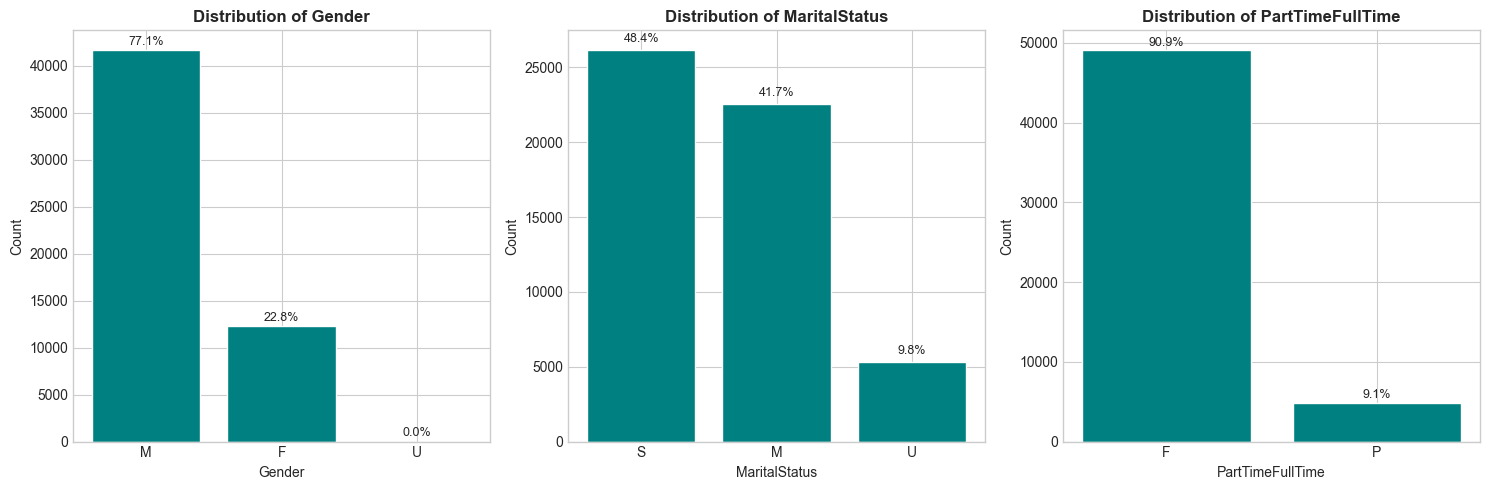

In [12]:
categorical_cols = ['Gender', 'MaritalStatus', 'PartTimeFullTime']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(categorical_cols):
    if col in df.columns:
        value_counts = df[col].value_counts()
        axes[i].bar(value_counts.index, value_counts.values, color='teal', edgecolor='white')
        axes[i].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')
        
        # Add percentage labels
        for idx, (cat, count) in enumerate(zip(value_counts.index, value_counts.values)):
            pct = count / len(df) * 100
            axes[i].text(idx, count + len(df)*0.01, f'{pct:.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

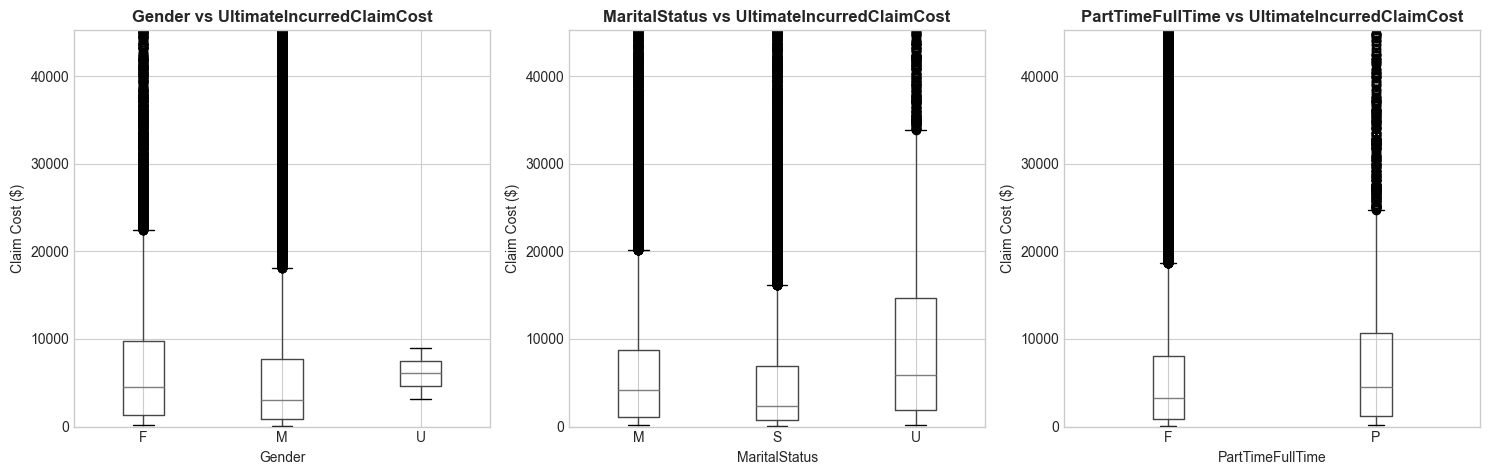

In [13]:
# Categorical vs Target (Box plots)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(categorical_cols):
    if col in df.columns:
        df.boxplot(column=target, by=col, ax=axes[i])
        axes[i].set_title(f'{col} vs {target}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Claim Cost ($)')
        axes[i].set_ylim(0, df[target].quantile(0.95))  # Focus on 95th percentile

plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.show()

### 💡 Categorical Insights
- **Gender**: Imbalanced (more males, typical in workers' comp data).
- **MaritalStatus**: Married (M) is the largest group.
- **PartTimeFullTime**: Full-time workers dominate.

---
## 5b. Text Analysis (NLP)
Analyzing `ClaimDescription` to understand common accident causes.

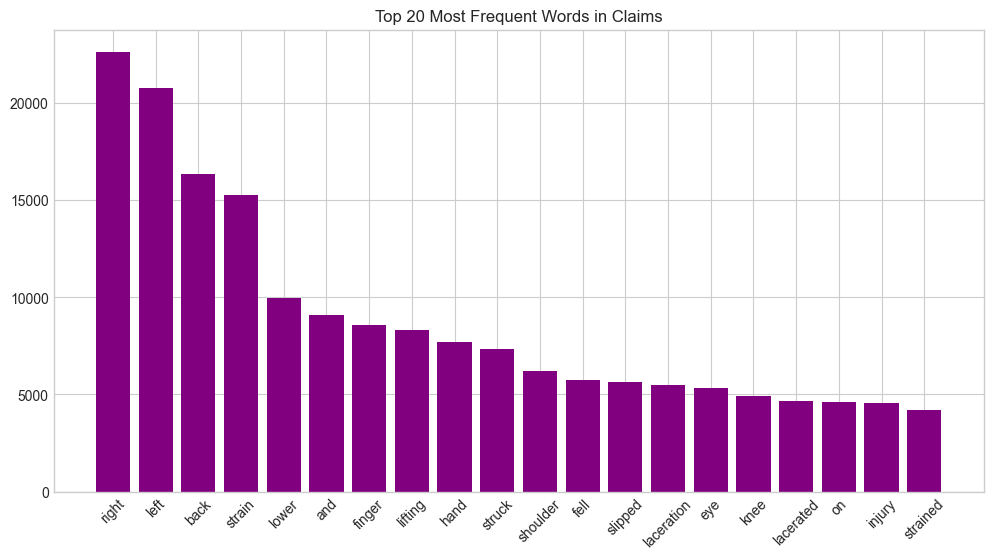

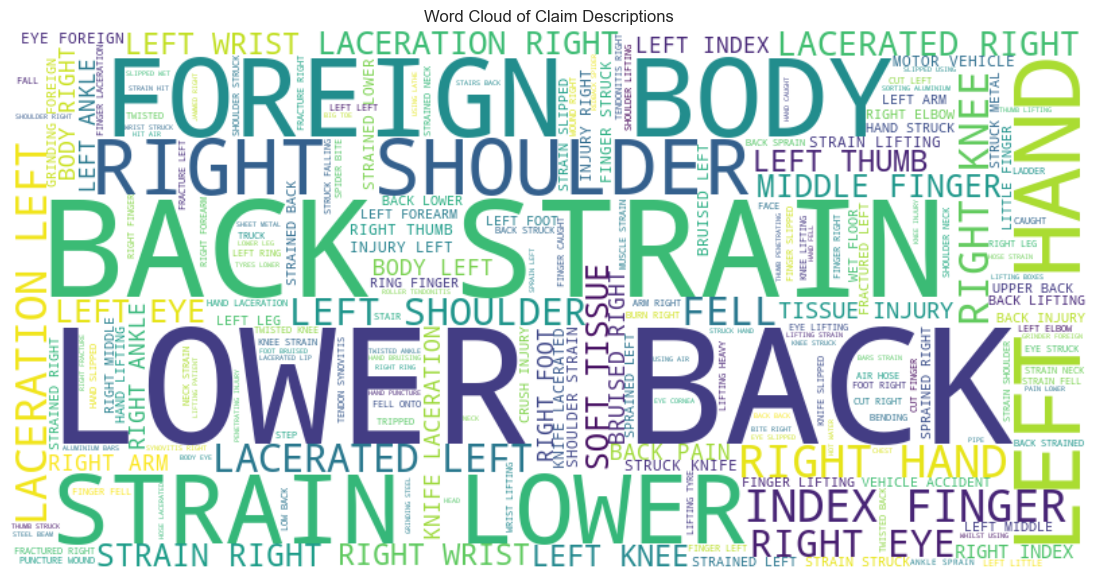

In [14]:
from wordcloud import WordCloud
from collections import Counter
import re

# Combine all descriptions
text_data = ' '.join(df['ClaimDescription'].dropna().astype(str).tolist())

# Basic cleaning
text_data_clean = re.sub(r'[^a-zA-Z\s]', '', text_data.lower())

# Word Frequency
words = text_data_clean.split()
word_counts = Counter(words)
common_words = word_counts.most_common(20)

plt.figure(figsize=(12, 6))
plt.bar([w[0] for w in common_words], [w[1] for w in common_words], color='purple')
plt.title('Top 20 Most Frequent Words in Claims')
plt.xticks(rotation=45)
plt.show()

try:
    # Generate WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Claim Descriptions')
    plt.show()
except ImportError:
    print("WordCloud library not found. Skipping visualization.")

### ⚙️ Feature Engineering: Text Dimensionality Reduction (SVD)
Implementing TF-IDF and SVD within EDA to validate if text components correlate with Cost.

Correlation of Top 5 SVD Components with Target:
svd_0    0.11
svd_1   -0.15
svd_2   -0.03
svd_3    0.10
svd_4    0.03
Name: UltimateIncurredClaimCost, dtype: float64


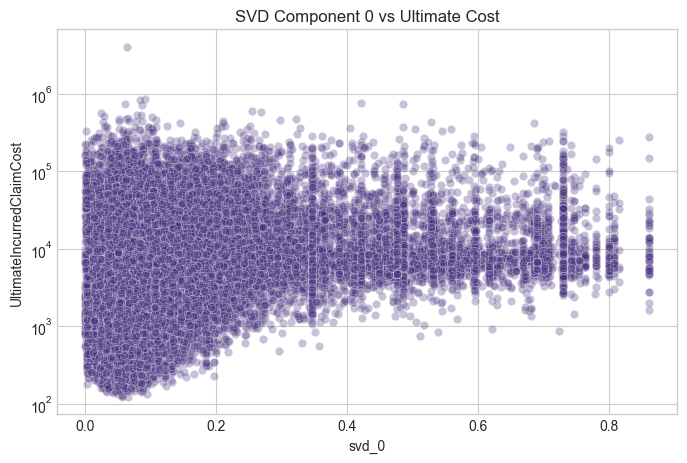

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1, 3))
tfidf_matrix = tfidf.fit_transform(df['ClaimDescription'].fillna(''))

# SVD (Latent Semantic Analysis)
svd = TruncatedSVD(n_components=5, random_state=42)
svd_components = svd.fit_transform(tfidf_matrix)

# Add to DataFrame for correlation analysis
for i in range(5):
    df[f'svd_{i}'] = svd_components[:, i]

# Correlation with Target
svd_cols = [f'svd_{i}' for i in range(5)]
corr_svd = df[svd_cols + ['UltimateIncurredClaimCost']].corr()['UltimateIncurredClaimCost']
print("Correlation of Top 5 SVD Components with Target:")
print(corr_svd.drop('UltimateIncurredClaimCost'))

# Visualizing the relationship (Top component)
plt.figure(figsize=(8, 5))
sns.scatterplot(x='svd_0', y='UltimateIncurredClaimCost', data=df, alpha=0.3)
plt.title('SVD Component 0 vs Ultimate Cost')
plt.yscale('log')
plt.show()

---
## 6. Correlation Analysis

In [16]:
# Compute correlation matrix for numerical columns
corr_cols = numerical_cols + [target]
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, linewidths=0.5, square=True)
plt.title('Correlation Matrix (Numerical Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

KeyError: "['InitialIncurredCalimsCost'] not in index"

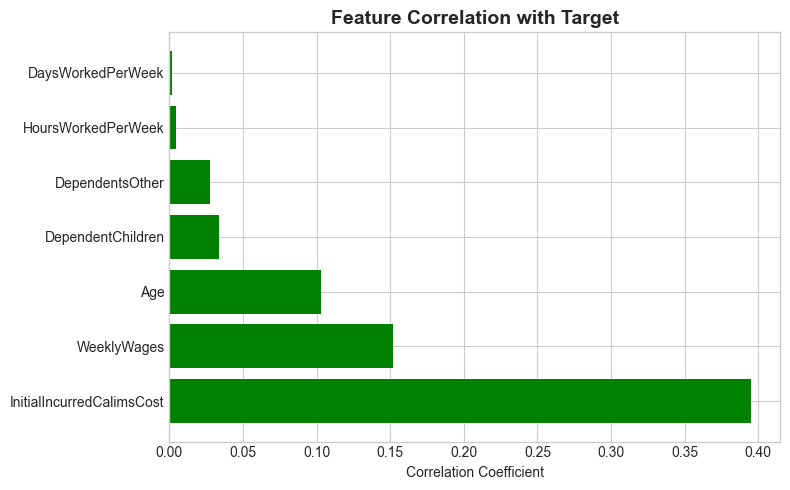

In [14]:
# Correlation with Target
target_corr = corr_matrix[target].drop(target).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
colors = ['green' if x > 0 else 'red' for x in target_corr.values]
plt.barh(target_corr.index, target_corr.values, color=colors)
plt.xlabel('Correlation Coefficient')
plt.title('Feature Correlation with Target', fontsize=14, fontweight='bold')
plt.axvline(0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

### 💡 Correlation Insights
- **InitialIncurredClaimsCost**: Strong positive correlation with target (expected - initial estimate drives final cost).
- **WeeklyWages**: Moderate positive correlation (higher wages → higher claims?).
- Other features have weak correlations, suggesting non-linear relationships or feature engineering opportunities.

---
## 6b. Temporal Analysis & Report Lag
Investigating how the delay in reporting affects the claim cost.

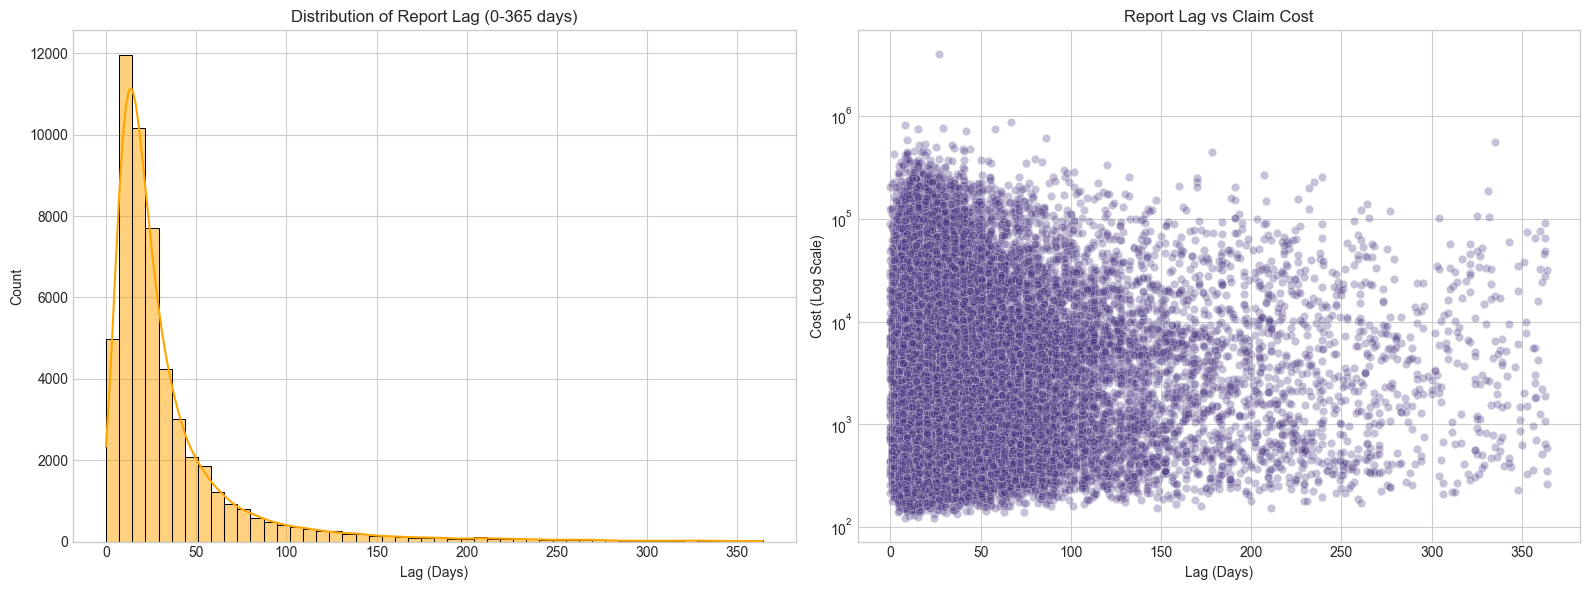

Average Report Lag: 38.32 days


In [17]:
# Convert dates if not already
df['DateTimeOfAccident'] = pd.to_datetime(df['DateTimeOfAccident'])
df['DateReported'] = pd.to_datetime(df['DateReported'])

# Calculate Report Lag
df['ReportLag'] = (df['DateReported'] - df['DateTimeOfAccident']).dt.days

# Filter negative lags (data errors) for visualization
valid_lags = df[(df['ReportLag'] >= 0) & (df['ReportLag'] < 365)]

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Distribution
sns.histplot(valid_lags['ReportLag'], bins=50, kde=True, ax=ax[0], color='orange')
ax[0].set_title('Distribution of Report Lag (0-365 days)')
ax[0].set_xlabel('Lag (Days)')

# Lag vs Cost
sns.scatterplot(x='ReportLag', y='UltimateIncurredClaimCost', data=valid_lags, alpha=0.3, ax=ax[1])
ax[1].set_title('Report Lag vs Claim Cost')
ax[1].set_yscale('log')
ax[1].set_xlabel('Lag (Days)')
ax[1].set_ylabel('Cost (Log Scale)')

plt.tight_layout()
plt.show()

print(f"Average Report Lag: {df['ReportLag'].mean():.2f} days")

---
## 7. Feature vs Target Relationships

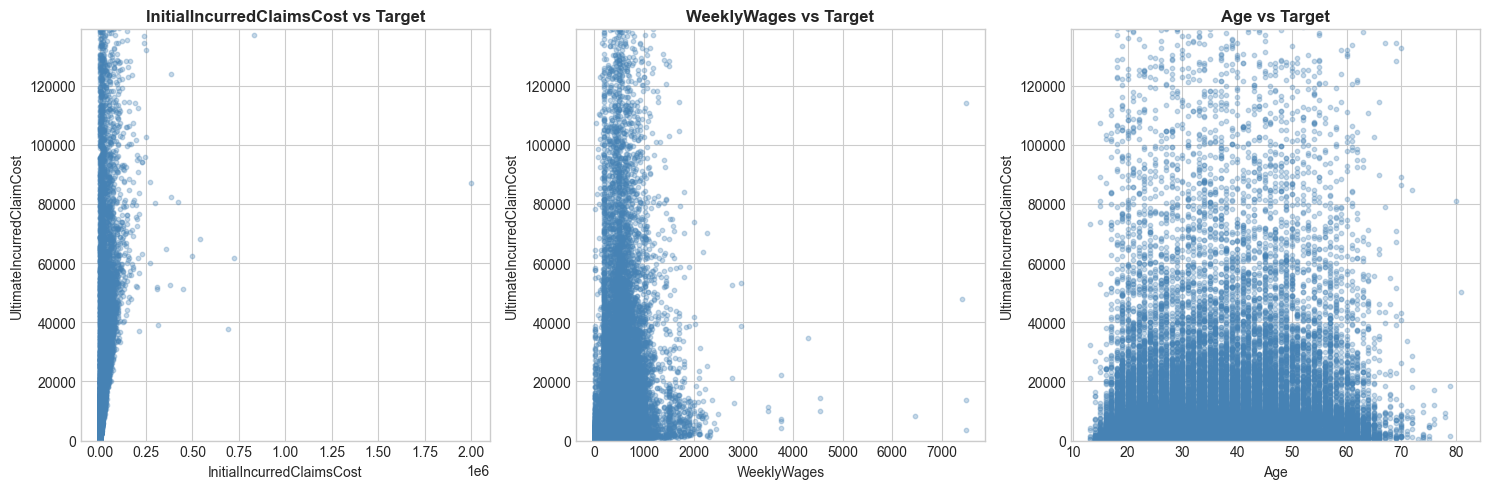

In [19]:
# Scatter plots for key features vs target
key_features = ['InitialIncurredClaimsCost', 'WeeklyWages', 'Age']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(key_features):
    axes[i].scatter(df[col], df[target], alpha=0.3, s=10, color='steelblue')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(target)
    axes[i].set_title(f'{col} vs Target', fontsize=12, fontweight='bold')
    axes[i].set_ylim(0, df[target].quantile(0.99))
    
plt.tight_layout()
plt.show()

---
## 8. Outlier Detection

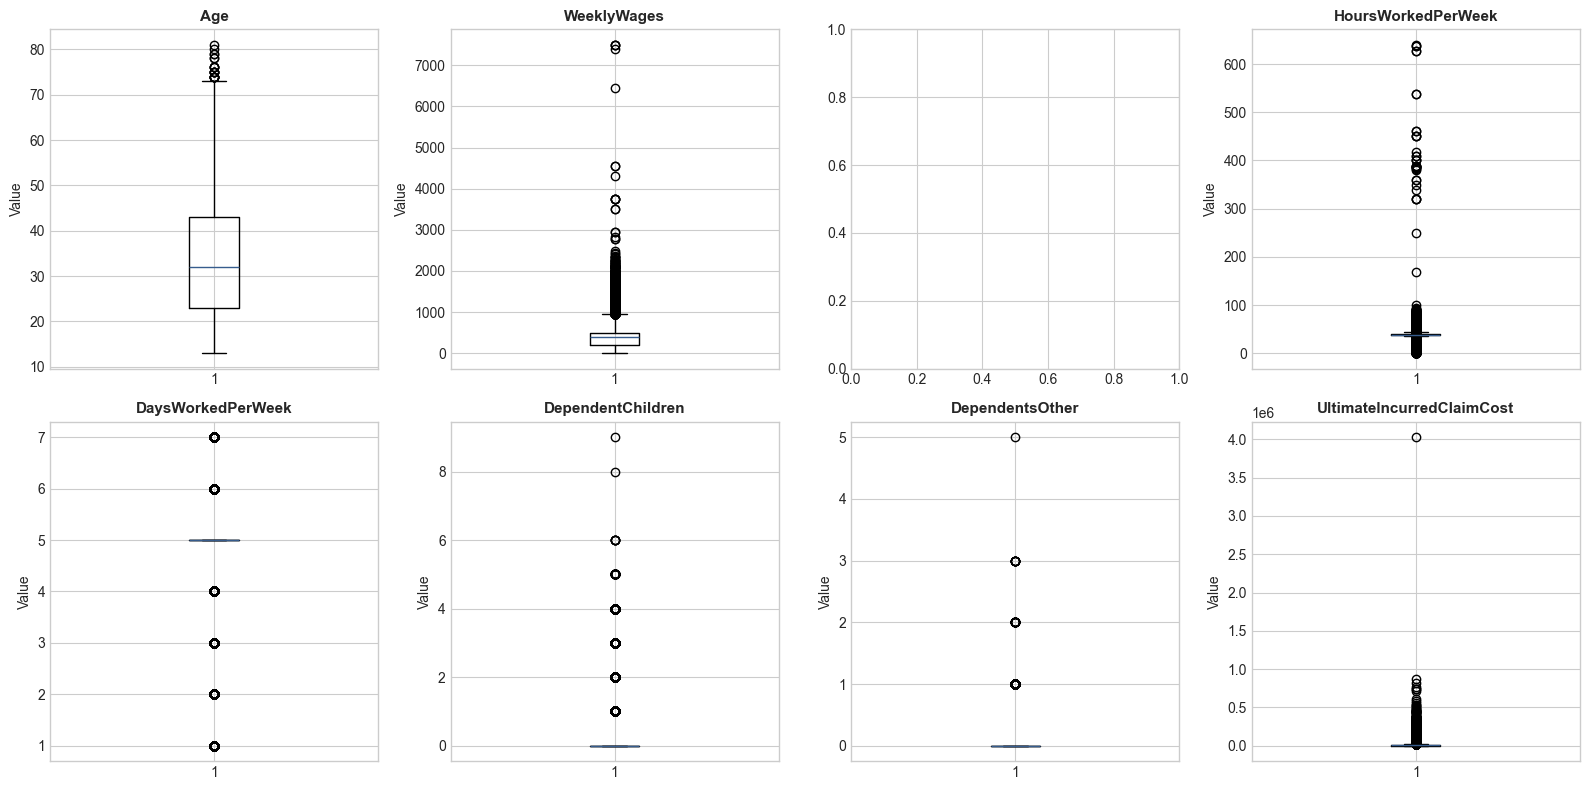

In [20]:
# Box plots for outlier detection
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

all_numeric = numerical_cols + [target]

for i, col in enumerate(all_numeric):
    if col in df.columns and i < len(axes):
        axes[i].boxplot(df[col].dropna(), vert=True)
        axes[i].set_title(f'{col}', fontsize=11, fontweight='bold')
        axes[i].set_ylabel('Value')

plt.tight_layout()
plt.show()

In [21]:
# Quantile analysis for target
print("Target Variable Percentiles:")
for q in [0.25, 0.50, 0.75, 0.90, 0.95, 0.99, 1.0]:
    val = df[target].quantile(q)
    print(f"  {int(q*100):3d}th percentile: ${val:,.2f}")

Target Variable Percentiles:
   25th percentile: $926.34
   50th percentile: $3,371.24
   75th percentile: $8,197.25
   90th percentile: $24,005.78
   95th percentile: $45,224.18
   99th percentile: $139,024.97
  100th percentile: $4,027,135.94


### 💡 Outlier Observations

- **Target**: Top 1% of claims exceed $139,024, with the maximum reaching over $4M.
- **InitialIncurredClaimsCost**: Shows a similar extreme long-tail distribution.
- **Consideration**: Robust scaling or log-transformation is essential. Tree-based models are preferred for their resistance to such outliers.

---
## 9. Key Insights & Recommendations

### 📌 Summary of Findings

| Aspect | Finding | Implication |
|--------|---------|-------------|
| **Target Distribution** | Extreme Skew (37.55) | Mandatory `log1p` transformation |
| **Key Predictor** | `InitialIncurredClaimsCost` | Strongest correlation; primary driver |
| **Missing Values** | Minimal (MaritalStatus: 0.05%) | Simple imputation (Mode) is sufficient |
| **Categorical Features** | Imbalanced (Gender, Marital) | Tree models handle this well; Label Encoding preffered |
| **Text Feature** | `ClaimDescription` available | Use TF-IDF + SVD for dimensionality reduction |
| **Date Features** | Accident and Report dates | Engineer `ReportLag`, `AccidentYear`, `AccidentMonth`, `DayOfWeek` |

### 🎯 Potential Feature Engineering
1. **Date Features**: `ReportLag = DateReported - DateTimeOfAccident`
2. **Log Transform**: `LogInitialCost = log1p(InitialIncurredClaimsCost)`
3. **Interaction**: `Age_Wage_Interaction = Age * WeeklyWages`
4. **NLP Features**: TF-IDF (1000 features) + TruncatedSVD (30 components) on `ClaimDescription`

### 🧠 Modeling Approach
- **Primary**: Gradient Boosting (XGBoost, LightGBM) - handles skewed data, non-linear relationships
- **Ensemble**: Stacking with Ridge meta-learner for robust predictions
- **Evaluation**: RMSE on original scale (after `expm1` transformation)